In [3]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.1.0+cu121


## Data Preparing & Loading

In [4]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

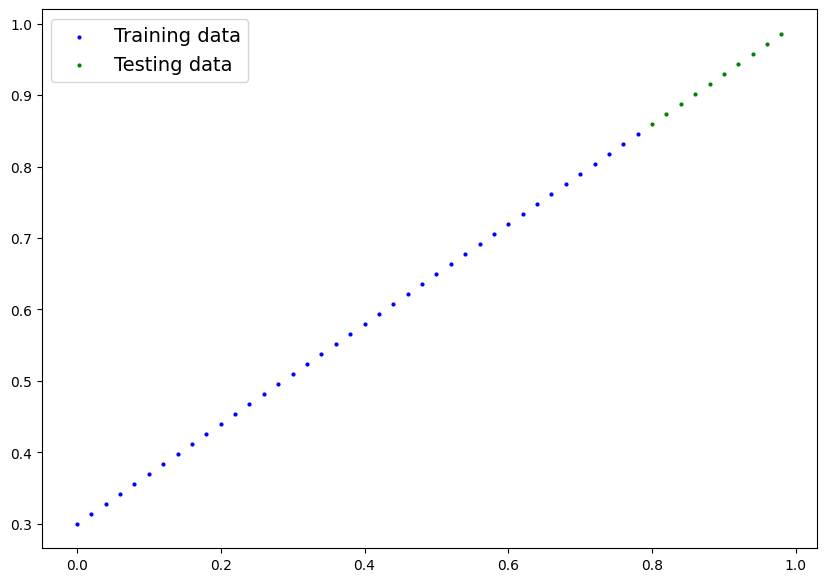

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

plot_predictions();

## Build Model

In [8]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                requires_grad=True)
    self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                             requires_grad=True)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

torch.manual_seed(36)
model = LinearRegressionModel()
list(model.parameters())

[Parameter containing:
 tensor([0.4704], requires_grad=True),
 Parameter containing:
 tensor([-0.0512], requires_grad=True)]

In [9]:
model.state_dict()

OrderedDict([('weights', tensor([0.4704])), ('bias', tensor([-0.0512]))])

In [10]:
with torch.inference_mode():
  y_preds = model(X_test)

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\m{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:\mtensor([[0.3251],
        [0.3345],
        [0.3439],
        [0.3533],
        [0.3627],
        [0.3721],
        [0.3815],
        [0.3909],
        [0.4003],
        [0.4097]])


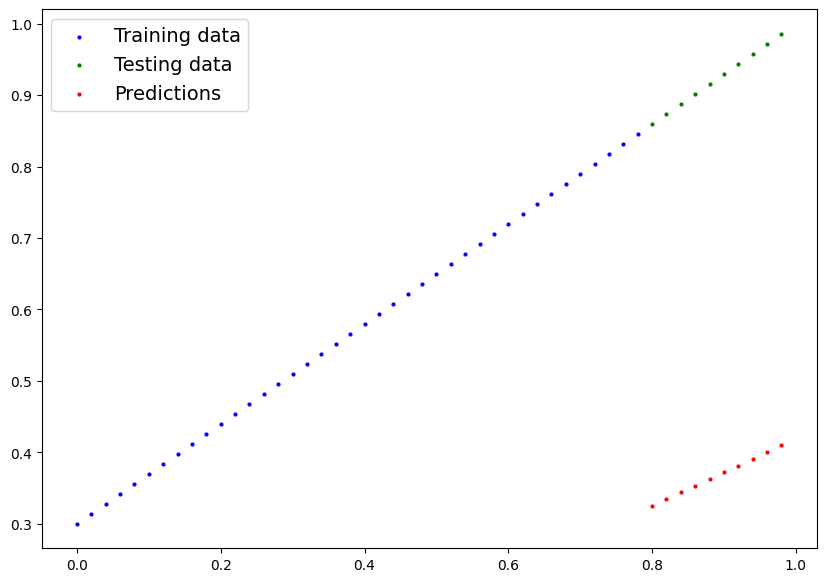

In [11]:
plot_predictions(predictions=y_preds)

## Training

In [12]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
  # Training
  model.train()

  # [1] Forward pass
  y_preds = model(X_train)

  # [2] Calculate the loss
  loss = loss_fn(y_preds, y_train)

  # [3] Zero gradients
  optimizer.zero_grad()

  # [4] Loss backwards
  loss.backward()

  # [5] Progress the optimizer
  optimizer.step()

  # Testing
  model.eval()

  with torch.inference_mode():
    # [1] Forward pass
    y_preds = model(X_test)

    # Calculate the loss
    test_loss = loss_fn(y_preds, y_test.type(torch.float))

    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.44079118967056274 | MAE Test Loss: 0.5421218872070312
Epoch: 10 | MAE Train Loss: 0.32558122277259827 | MAE Test Loss: 0.40741196274757385
Epoch: 20 | MAE Train Loss: 0.21037128567695618 | MAE Test Loss: 0.27270203828811646
Epoch: 30 | MAE Train Loss: 0.09516123682260513 | MAE Test Loss: 0.13799205422401428
Epoch: 40 | MAE Train Loss: 0.015368292108178139 | MAE Test Loss: 0.037895649671554565
Epoch: 50 | MAE Train Loss: 0.011517633683979511 | MAE Test Loss: 0.02622426673769951
Epoch: 60 | MAE Train Loss: 0.008079780265688896 | MAE Test Loss: 0.0179517213255167
Epoch: 70 | MAE Train Loss: 0.00464413920417428 | MAE Test Loss: 0.010366052389144897
Epoch: 80 | MAE Train Loss: 0.0016544871032238007 | MAE Test Loss: 0.0034387886989861727
Epoch: 90 | MAE Train Loss: 0.006500396877527237 | MAE Test Loss: 0.0034387886989861727


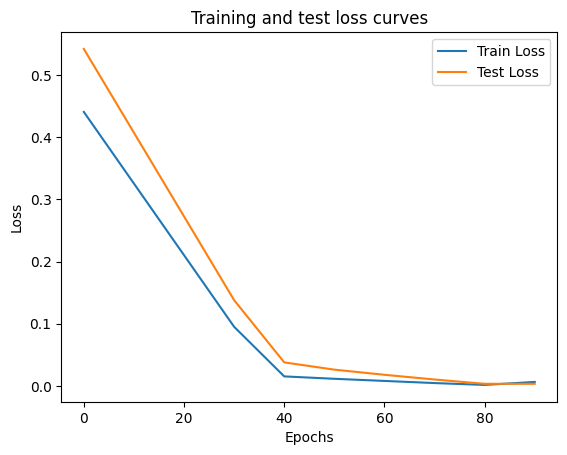

In [13]:
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [14]:
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6929])), ('bias', tensor([0.2963]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Inference

In [15]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)
y_preds

tensor([[0.8506],
        [0.8645],
        [0.8783],
        [0.8922],
        [0.9060],
        [0.9199],
        [0.9338],
        [0.9476],
        [0.9615],
        [0.9753]])

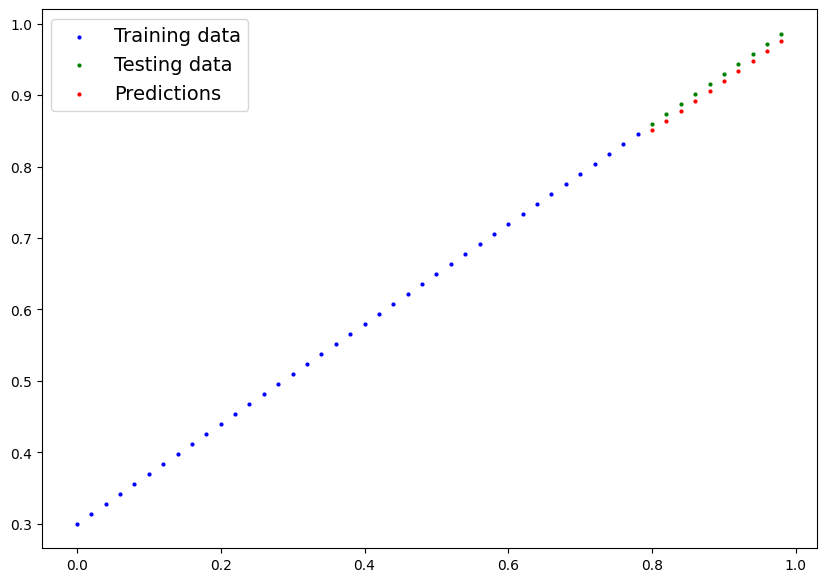

In [16]:
plot_predictions(predictions=y_preds)